In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [2]:
control_df = pd.read_csv('./../../../Datasets/UKEssen/NSCLC_Non-Pembro_GENIE_13-05-2025.csv')
treat_df = pd.read_csv('./../../../Datasets/UKEssen/NSCLC_Pembro_MSKCHORD_13-05-2025.csv')


In [3]:
treat_df = treat_df.rename(columns={'TTF_Pembro': 'TTF',
    'TTF_Pembro_observed': 'TTF_observed',
    'PFS_Pembro': 'PFS',
    'PFS_Pembro_observed': 'PFS_observed',
    'OS_Pembro': 'OS',
    'OS_Pembro_observed': 'OS_observed'
})
merged_df = pd.concat([control_df, treat_df], ignore_index=True, sort=False)
merged_df = merged_df.rename(columns={'ICD-O Histology Description': 'Histopathology', 
                  'History for Positive PD-L1 (NLP)':'Pos_PD-L1',
                  'Smoking History (NLP)': 'Smoker'})

merged_df = merged_df.drop('Ethnicity', axis=1)

In [4]:
histo = set(list(merged_df['Histopathology']))

for h in histo:
    print(h)

Other histologies/mixed tumor
nan
Adenocarcinoma Combined With Other Types Of Carcinoma
Acinar Cell Carcinoma
Adenocarcinoma, Nos
Acinar Cell Cystadenocarcinoma
Solid Carcinoma, Nos
Adenosquamous Carcinoma
Bronchiolo-Alveolar Ca Mixed Muc/Non Mucinous (C34._)
Sq Cell Ca, Large Cell, Non-Keratinizing
Squamous Cell Carcinoma, Nos
Large Cell Neuroendocrine Carcinoma
Mucinous Adenocarcinoma
Giant Cell & Spindle Cell Carcinoma
Pleomorphic Carcinoma
Non-Small Cell Carcinoma (C34._)
Sq Cell Ca, Keratinizing Type, Nos
Mucin-Producing Adenocarinoma
Carcinoma, Nos
Neuroendocrine Carcinoma
Bronchiolo-Alveolar Carcinoma, Mucinous (C34._)
Small cell carcinoma
Small Cell Carcinoma, Nos
Adenocarcinoma
Carcinoma
Papillary Adenocarcinoma, Nos
Pseudosarcomatous Carcinoma
Squamous cell


In [5]:
merged_df['Histopathology'] = merged_df['Histopathology'].replace({
    'Squamous Cell Carcinoma, Nos': 'Squamous Cell',
    'Small cell carcinoma': 'Small Cell Carcinoma, Nos',
    'Carcinoma, Nos': 'Carcinoma',
    'Papillary Adenocarcinoma, Nos': 'Adenocarcinoma',
    'Mucin-Producing Adenocarinoma': 'Mucinous Adenocarcinoma',
    'Bronchiolo-Alveolar Ca Mixed Muc/Non Mucinous (C34._)': 'Bronchiolo-Alveolar Carcinoma, Mucinous (C34._)',
})

In [6]:
def group_histology(label):
    label = str(label).lower()
    
    if any(sub in label for sub in [
        'adenocarcinoma', 'acinar', 'mucin', 'bronchiolo'
    ]):
        return 'Adenocarcinoma'
    
    elif 'squamous' in label:
        return 'Squamous_Cell_Carcinoma'
    
    elif 'small cell' in label:
        return 'Small_Cell_Carcinoma'
    
    elif any(sub in label for sub in [
        'pleomorphic', 'pseudosarcomatous', 'giant cell', 'solid',
        'mixed tumor', 'non-small cell'
    ]):
        return 'Other'
    
    elif any(sub in label for sub in [
        'neuroendocrine', 'carcinoma'
    ]) or label == 'nan':
        return 'Unspecified'
    
    else:
        return 'Other'

merged_df['Histopathology_Grouped_Type'] = merged_df['Histopathology'].apply(group_histology)


In [7]:
def group_histology_size(label):
    label = str(label).lower()
    
    if 'large' in label:
        return 'Large'
    
    elif 'small' in label:
        return 'Small'
    else:
        return 'Other'

merged_df['Histopathology_Grouped_Size'] = merged_df['Histopathology'].apply(group_histology_size)


In [8]:
histo = set(list(merged_df['Histopathology_Grouped_Size']))

for h in histo:
    print(h)

Small
Large
Other


In [9]:
print(np.unique(merged_df['Histopathology_Grouped_Size'], return_counts=True))
print(np.unique(merged_df['Histopathology_Grouped_Type'], return_counts=True))

(array(['Large', 'Other', 'Small'], dtype=object), array([  15, 1380,   16]))
(array(['Adenocarcinoma', 'Other', 'Small_Cell_Carcinoma',
       'Squamous_Cell_Carcinoma', 'Unspecified'], dtype=object), array([1085,   49,   16,  116,  145]))


In [10]:
# Apply group_tumor_site to each row in merged_df to create a new column 'Tumor_Site_Grouped'
def get_tumor_site_group(row):
    # Check each tumor site column for presence (value == 1 or True)
    if row.get('TUMOR_SITE_Liver', 0) == 1 or row.get('TUMOR_SITE_Intra-Abdominal', 0) == 1 or row.get('TUMOR_SITE_Thorax', 0) == 1:
        return 'Visceral'
    elif row.get('TUMOR_SITE_Bone', 0) == 1:
        return 'Skeletal'
    elif row.get('TUMOR_SITE_CNS/Brain', 0) == 1:
        return 'CNS'
    else:
        return 'Other'

merged_df['Tumor_Site_Grouped'] = merged_df.apply(get_tumor_site_group, axis=1)

In [11]:
# Apply group_tumor_site to each row in merged_df to create a new column 'Tumor_Site_Grouped'
def get_tumor_site(row):
    # Check each tumor site column for presence (value == 1 or True)
    if row.get('TUMOR_SITE_Liver', 0) == 1:
        return 'Liver'
    elif row.get('TUMOR_SITE_Intra-Abdominal', 0) == 1:
        return 'Abdominal'
    elif row.get('TUMOR_SITE_Thorax', 0) == 1:
        return 'Thorax'
    elif row.get('TUMOR_SITE_Bone', 0) == 1:
        return 'Skeletal'
    elif row.get('TUMOR_SITE_CNS/Brain', 0) == 1:
        return 'CNS'
    else:
        return 'Other'

merged_df['Tumor_Site'] = merged_df.apply(get_tumor_site, axis=1)

In [12]:
print(np.unique(merged_df['Tumor_Site_Grouped'], return_counts=True))
print(np.unique(merged_df['Tumor_Site'], return_counts=True))

(array(['CNS', 'Other', 'Skeletal', 'Visceral'], dtype=object), array([  66,  126,  111, 1108]))
(array(['Abdominal', 'CNS', 'Liver', 'Other', 'Skeletal', 'Thorax'],
      dtype=object), array([234,  66, 222, 126, 111, 652]))


In [13]:
def extract_treatments(regimen_series):
    # Split by comma, strip whitespace, flatten, and get unique treatments
    treatments = set()
    for regimens in regimen_series.dropna():
        for treatment in regimens.split(','):
            treatments.add(treatment.strip().upper())
    return sorted(treatments)

# Get all unique treatments in both datasets
all_treatments = set(extract_treatments(control_df['Regimen'])) | set(extract_treatments(treat_df['Regimen']))

| Group                        | Medications                                                                                                                                                                                                                                                         | Rationale                                   |
| ---------------------------- | ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- | ------------------------------------------- |
| **1. Chemotherapy**          | `CARBOPLATIN`, `CISPLATIN`, `OXALIPLATIN`, `DOCETAXEL`, `PACLITAXEL`, `NABPACLITAXEL`, `PACLITAXEL PROTEIN-BOUND`, `PEMETREXED`, `PEMETREXED DISODIUM`, `ETOPOSIDE`, `GEMCITABINE`, `GEMCITABINE HYDROCHLORIDE`, `VINORELBINE TARTRATE`, `FLUOROURACIL`, `THIOTEPA` | Classic cytotoxic agents                    |
| **2. Targeted Therapy**      | `AFATINIB DIMALEATE`, `ERLOTINIB HYDROCHLORIDE`, `GEFITINIB`, `ICOTINIB`, `OSIMERTINIB`, `CRIZOTINIB`, `ALECTINIB`, `DABRAFENIB`, `TRAMETINIB`, `CABOZANTINIB SMALATE`                                                                                              | EGFR, ALK, BRAF, MEK, MET inhibitors        |
| **3. Immunotherapy**         | `PEMBROLIZUMAB`                                                                                                                                                                                                                                                     | Anti–PD-1 checkpoint inhibitor              |
| **4. Monoclonal Antibodies** | `CETUXIMAB`, `NECITUMUMAB`, `BEVACIZUMAB`                                                                                                                                                                                                                           | EGFR or VEGF-directed monoclonal antibodies |
| **5. Other / Unknown**       | `INVESTIGATIONAL DRUG`, `OTHER ANTINEOPLASTIC`, `OTHER NOS`                                                                                                                                                                                                         | Non-specific or unknown category            |


Another question: are there duplicates here? 

In [14]:
def group_medication_coarse(med):

    # this is wrong because it misses the combinations
    med = str(med).upper()
    
    chemo = {
        'CARBOPLATIN', 'CISPLATIN', 'OXALIPLATIN', 'DOCETAXEL',
        'PACLITAXEL', 'NABPACLITAXEL', 'PACLITAXEL PROTEIN-BOUND',
        'PEMETREXED', 'PEMETREXED DISODIUM', 'ETOPOSIDE', 'GEMCITABINE',
        'GEMCITABINE HYDROCHLORIDE', 'VINORELBINE TARTRATE', 'FLUOROURACIL', 'THIOTEPA'
    }
    
    targeted = {
        'AFATINIB DIMALEATE', 'ERLOTINIB HYDROCHLORIDE', 'GEFITINIB', 'ICOTINIB',
        'OSIMERTINIB', 'CRIZOTINIB', 'ALECTINIB', 'DABRAFENIB',
        'TRAMETINIB', 'CABOZANTINIB SMALATE'
    }
    
    immuno = {'PEMBROLIZUMAB'}
    
    antibodies = {'CETUXIMAB', 'NECITUMUMAB', 'BEVACIZUMAB'}
    
    other = {'INVESTIGATIONAL DRUG', 'OTHER ANTINEOPLASTIC', 'OTHER NOS'}
    

    if med in chemo:
        return 'Chemotherapy'
    elif med in targeted:
        return 'Targeted Therapy'
    elif med in immuno:
        return 'Immunotherapy/Pembro'
    elif med in antibodies:
        return 'Monoclonal Antibody'
    elif med in other:
        return 'Other/Unknown'
    else:
        return 'Unclassified'


In [15]:
merged_df['Regimen_Grouped'] = merged_df['Regimen'].apply(group_medication_coarse)

In [16]:
treatments, counts = np.unique(merged_df['Regimen'], return_counts=True)
all_treatments = []

for treatment in treatments:
    substances = treatment.split(',')
    for s in substances:
        s = s.lower()
        s = s.strip(' ')
        all_treatments.append(s.lower())

all_treatments = list(set(all_treatments))

recode = dict()
for t in all_treatments:
    for t2 in all_treatments:
        if t != t2:
             if (t2 in t):
                recode[t] = t2

In [17]:
for i in range(len(all_treatments)):
    if all_treatments[i] in recode.keys():
        all_treatments[i] = recode[all_treatments[i]]

In [18]:
recode

{'gemcitabine hydrochloride': 'gemcitabine',
 'nabpaclitaxel': 'paclitaxel',
 'paclitaxel protein-bound': 'paclitaxel',
 'pemetrexed disodium': 'pemetrexed'}

In [19]:
regimen = merged_df['Regimen'].copy().to_numpy()
cleaned_regimen = []
for r in regimen:
    substances = r.split(',')
    for i in range(len(substances)):
        substances[i] = substances[i].strip(' ').lower()
        # check if replacement is necessary
        if substances[i] in recode.keys():
            substances[i] = recode[substances[i]]
    substances = list(set(substances))
    cleaned_string = ', '.join(substances)
    cleaned_regimen.append(cleaned_string)

In [20]:
merged_df['Cleaned_Regimen'] = cleaned_regimen

In [21]:
sorted_indices = np.argsort(counts)
for i in range (len(sorted_indices) - 1, 0, -1):
    idx = sorted_indices[i]
    print(treatments[idx], counts[idx])

CARBOPLATIN, PEMBROLIZUMAB, PEMETREXED 381
PEMBROLIZUMAB 288
Carboplatin, Pemetrexed Disodium 143
Erlotinib Hydrochloride 82
Bevacizumab, Carboplatin, Pemetrexed Disodium 63
Cisplatin, Pemetrexed Disodium 45
CARBOPLATIN, PACLITAXEL, PEMBROLIZUMAB 41
Investigational Drug, Investigational Drug 36
CISPLATIN, PEMBROLIZUMAB, PEMETREXED 35
Bevacizumab, Cisplatin, Pemetrexed Disodium 31
CARBOPLATIN, PACLITAXEL PROTEIN-BOUND, PEMBROLIZUMAB 31
Investigational Drug 30
Carboplatin, Paclitaxel 27
Crizotinib 23
PEMBROLIZUMAB, PEMETREXED 15
Carboplatin, Gemcitabine Hydrochloride 12
Bevacizumab, Carboplatin, Paclitaxel 11
Afatinib Dimaleate 11
Carboplatin, Nabpaclitaxel 9
Osimertinib 8
Cisplatin, Gemcitabine Hydrochloride 7
Gemcitabine Hydrochloride, Vinorelbine Tartrate 4
Cisplatin, Docetaxel 4
Cisplatin, Investigational Drug, Pemetrexed Disodium 4
Cisplatin, Etoposide 4
Carboplatin, Docetaxel 3
Carboplatin, Investigational Drug, Pemetrexed Disodium 3
Pemetrexed Disodium 3
Alectinib 3
Vinorelbine Ta

In [22]:
cleaned_treat, cleaned_counts = np.unique(merged_df['Cleaned_Regimen'], return_counts=True)
sorted_cleaned_indices = np.argsort(cleaned_counts)
for i in range (len(sorted_cleaned_indices) - 1, 0, -1):
    idx = sorted_cleaned_indices[i]
    print(idx, cleaned_treat[idx], cleaned_counts[idx])

15 carboplatin, pemetrexed, pembrolizumab 381
51 pembrolizumab 288
13 carboplatin, pemetrexed 143
33 erlotinib hydrochloride 82
12 carboplatin, pembrolizumab, paclitaxel 74
43 investigational drug 67
14 carboplatin, pemetrexed, bevacizumab 63
25 cisplatin, pemetrexed 45
10 carboplatin, paclitaxel 36
28 cisplatin, pemetrexed, pembrolizumab 35
26 cisplatin, pemetrexed, bevacizumab 31
30 crizotinib 23
58 pemetrexed, pembrolizumab 15
37 gemcitabine, carboplatin 12
49 paclitaxel, carboplatin, bevacizumab 11
0 afatinib dimaleate 11
44 osimertinib 8
21 cisplatin, gemcitabine 7
27 cisplatin, pemetrexed, investigational drug 4
20 cisplatin, etoposide 4
19 cisplatin, docetaxel 4
9 carboplatin, investigational drug, pemetrexed 4
62 vinorelbine tartrate, gemcitabine 4
1 alectinib 3
36 gefitinib 3
55 pemetrexed 3
5 carboplatin, docetaxel 3
61 vinorelbine tartrate 3
29 cisplatin, vinorelbine tartrate 3
50 paclitaxel, pemetrexed, bevacizumab 3
18 cisplatin, carboplatin, pemetrexed, pembrolizumab 2
6 

In [29]:
vals_to_drop = []
for i in range(len(cleaned_treat) - 6, 0, -1):
    vals_to_drop.append(cleaned_treat[sorted_cleaned_indices[i]])

In [30]:
merged_df['Cleaned_Regimen'].isin(vals_to_drop)

0       False
1       False
2       False
3       False
4        True
        ...  
1406    False
1407    False
1408    False
1409    False
1410    False
Name: Cleaned_Regimen, Length: 1411, dtype: bool

In [34]:
reduced_merged_df = merged_df[~merged_df['Cleaned_Regimen'].isin(vals_to_drop)].copy()

In [35]:
np.unique(reduced_merged_df['Cleaned_Regimen'])

array(['carboplatin, pembrolizumab, paclitaxel',
       'carboplatin, pemetrexed',
       'carboplatin, pemetrexed, pembrolizumab',
       'dabrafenib, pembrolizumab', 'erlotinib hydrochloride',
       'pembrolizumab'], dtype=object)

In [36]:
race_replacement = {'asian-far east/indian subcont': 'POC', 
                    'american indian, aleutian, or eskimo': 'POC', 
                    'asian-far east/indian subcont': 'POC',
                    'chinese': 'POC',
                     'native hawaiian or pacific isl':'POC',
                     'no value entered': 'NA',
                     'other': 'NA',
                     'other asian': 'POC',
                     'pt refused to answer': 'NA',
                     'black': 'POC',
                     'black or african american': 'POC',
                     'unknown': 'NA'}

reduced_merged_df['Grouped_Race'] = reduced_merged_df['Race'].copy()
reduced_merged_df['Grouped_Race'] = [r.lower() for r in reduced_merged_df['Race']]
reduced_merged_df['Grouped_Race'] = reduced_merged_df['Grouped_Race'].replace(race_replacement)

In [37]:
print(np.unique(reduced_merged_df['Race'], return_counts=True))
print(np.unique(reduced_merged_df['Grouped_Race'], return_counts=True))



(array(['ASIAN-FAR EAST/INDIAN SUBCONT', 'BLACK OR AFRICAN AMERICAN',
       'Black', 'Chinese', 'NATIVE HAWAIIAN OR PACIFIC ISL', 'OTHER',
       'Other', 'Other Asian', 'PT REFUSED TO ANSWER', 'UNKNOWN',
       'Unknown', 'WHITE', 'White'], dtype=object), array([ 57,  40,  12,  13,   1,  21,   5,  11,   8,  13,   8, 604, 176]))
(array(['NA', 'POC', 'white'], dtype=object), array([ 55, 134, 780]))


In [39]:
reduced_merged_df['Sex'] = [s.lower() for s in reduced_merged_df['Sex']]

In [41]:

# Step 1: Define covariates and treatment
covariate_cols = ['Current Age', 'Sex', 'Grouped_Race'] 
categorical_cols = ['Sex', 'Grouped_Race']  # columns to one-hot encode
numeric_cols = list(set(covariate_cols) - set(categorical_cols))

X = reduced_merged_df[covariate_cols]
T = reduced_merged_df['Cleaned_Regimen']

# Step 2: Create preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first'), categorical_cols),
        ('num', 'passthrough', numeric_cols)
    ]
)

# Step 3: Fit logistic regression pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('logreg', LogisticRegression(max_iter=1000))
])

pipeline.fit(X, T)

# Step 4: Predict propensity scores
reduced_merged_df['propensity_score'] = pipeline.predict_proba(X)[:, 1]

/opt/anaconda3/envs/tigramite/lib/python3.10/site-packages/sklearn/linear_model/_linear_loss.py:203: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights.T + intercept  # ndarray, likely C-contiguous
/opt/anaconda3/envs/tigramite/lib/python3.10/site-packages/sklearn/linear_model/_linear_loss.py:203: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights.T + intercept  # ndarray, likely C-contiguous
/opt/anaconda3/envs/tigramite/lib/python3.10/site-packages/sklearn/linear_model/_linear_loss.py:203: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights.T + intercept  # ndarray, likely C-contiguous
/opt/anaconda3/envs/tigramite/lib/python3.10/site-packages/sklearn/linear_model/_linear_loss.py:336: RuntimeWarning: divide by zero encountered in matmul
  grad[:, :n_features] = grad_pointwise.T @ X + l2_reg_strength * weights
/opt/anaconda3/envs/tigramite/lib/python3.10/site-packages/sklearn/linear_model/_linea

In [43]:
reduced_merged_df[reduced_merged_df['Cleaned_Regimen'] == 'carboplatin, pemetrexed, pembrolizumab']['propensity_score']

606     0.286627
646     0.138494
667     0.166162
668     0.317030
675     0.178680
          ...   
1406    0.159822
1407    0.280873
1408    0.111771
1409    0.108230
1410    0.131781
Name: propensity_score, Length: 381, dtype: float64

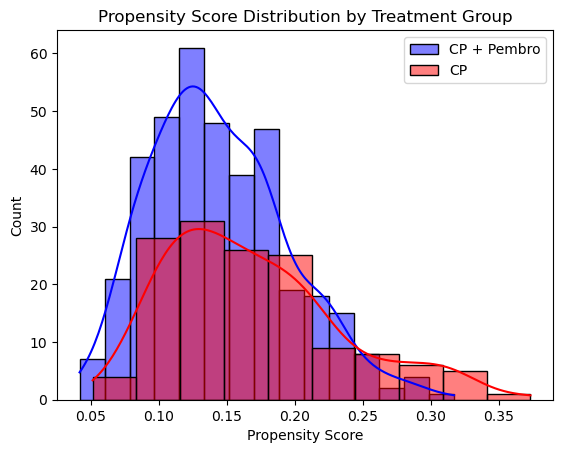

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(reduced_merged_df[reduced_merged_df['Cleaned_Regimen'] == 'carboplatin, pemetrexed, pembrolizumab']['propensity_score'], color='blue', label='CP + Pembro', kde=True)
sns.histplot(reduced_merged_df[reduced_merged_df['Cleaned_Regimen'] == 'carboplatin, pemetrexed']['propensity_score'], color='red', label='CP', kde=True)
plt.title("Propensity Score Distribution by Treatment Group")
plt.xlabel("Propensity Score")
plt.ylabel("Count")
plt.legend()
plt.show()
